In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider

In [2]:
data = np.loadtxt('./wine.data.txt', delimiter=',')
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']
train_size = 130
np.random.seed(0)
perm = np.random.permutation(data.shape[0])
trainx = data[perm[:train_size],1:14]
trainy = data[perm[:train_size],0]
testx = data[perm[train_size:],1:14]
testy = data[perm[train_size:],0]

In [3]:
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

(130, 13) (130,) (48, 13) (48,)


In [4]:
#help(np.cov)
def fit_guassian(x, features):
    mu = np.mean(x[:,features], axis=0)
    covar = np.cov(x[:,features], rowvar=0, bias=1)
    return mu, covar

In [5]:
f1 = 0
f2 = 6
label = 1
mu, covar = fit_guassian(trainx[trainy==label,:], [f1,f2])
print("Mean: " + str(mu))
print("Covariance matrix: " + str(covar))

Mean: [13.78534884  2.99627907]
Covariance matrix: [[0.23325279 0.07526874]
 [0.07526874 0.15240941]]


In [6]:
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2*width
    upper = upper + 0.2*width
    return lower, upper

In [7]:
def plot_contours(mu, cov, x1g, x2g, col):
    rv = multivariate_normal(mean=mu, cov=cov)
    z = np.zeros((len(x1g), len(x2g)))
    for i in range(0, len(x1g)):
        for j in range(0, len(x2g)):
            z[j,i] = rv.logpdf([x1g[i],x2g[j]])
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2*np.log(6.28) + sign*logdet)
    for offset in range(1,4):
        plt.contour(x1g,x2g,z,levels=[normalizer-offset],colors=col,
                   linewidth=2.0, linestyles='solid')

In [8]:
@interact_manual(f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1), label=IntSlider(1,1,3,1))
def two_features_plot(f1, f2, label):
    if f1==f2:
        print("Please choose different features for f1 and f2.")
        return
    x1_lower, x1_upper = find_range(trainx[trainy==label,f1])
    x2_lower, x2_upper = find_range(trainx[trainy==label,f2])
    plt.xlim(x1_lower, x1_upper)
    plt.ylim(x2_lower, x2_upper)
    plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], 'ro')
    
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)
    
    mu,cov = fit_guassian(trainx[trainy==label,:],[f1,f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Class ' + str(label), fontsize=14, color='blue')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=12), IntSlider(value=6, description='f2', max=12), IntSlider(value=1, description='label', max=3, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [9]:
def fit_generative_model(x, y, features):
    k = 3
    d = len(features)
    mu = np.zeros((k+1,d))
    covar = np.zeros((k+1,d,d))
    pi = np.zeros(k+1)
    for label in range(1, k+1):
        indices = (y==label)
        mu[label,:],covar[label,:,:] = fit_guassian(x[indices,:],features)
        pi[label] = float(sum(indices))/float(len(y))
    return mu, covar, pi

In [10]:
@interact_manual(f1=IntSlider(0,0,12,1), f2=IntSlider(6,0,12,1))
def three_class_plot(f1, f2):
    if f1==f2:
        print("Please choose different features for f1 and f2.")
        return
    x1_lower, x1_upper = find_range(trainx[:,f1])
    x2_lower, x2_upper = find_range(trainx[:,f2])
    plt.xlim(x1_lower, x1_upper)
    plt.ylim(x2_lower, x2_upper)
    
    colors = ['r','k','g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1],trainx[trainy==label,f2],marker='o',ls='None',
                c=colors[label-1])
        
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)
    
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    for label in range(1,4):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])
        
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Wind data', fontsize=14, color='blue')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=12), IntSlider(value=6, description='f2', max=12), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## 4. Predict labels for the test points

In [37]:
#@interact(f1 = IntSlider(0,0,12,1), f2 = IntSlider(6,0,12,1))
def test_model(f1, f2):
    if f1==f2:
        print("Please choose different features for f1 and f2.")
        return
    features = [f1, f2]
    mu, covar, pi = fit_generative_model(trainx, trainy, features)
    
    k = 3
    nt = len(testy)
    score = np.zeros((nt, k+1))
    for i in range(0, nt):
        for label in range(1, k+1):
            score[i,label] = np.log(pi[label]) + \
            multivariate_normal.logpdf(testx[i,features], mean=mu[label,:],
                                       cov=covar[label,:,:])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    errors = np.sum(predictions != testy)
    print("Test error using features(s):")
    for f in features:
            print("'" + featurenames[f] + "'" + " ")
    print("Errors: " + str(errors) + "/" + str(nt))
    return errors

In [17]:
len(featurenames)

13

In [49]:
### build a table of errors
num_features = len(featurenames)
error_table = np.zeros((num_features,num_features))
error_table.fill(100)
for f1 in range(0,num_features):
    for f2 in range(f1+1, num_features):
        error_table[f1, f2] = test_model(f1, f2)
        print(error_table[f1,f2])

Test error using features(s):
'Alcohol' 
'Malic acid' 
Errors: 9/48
9.0
Test error using features(s):
'Alcohol' 
'Ash' 
Errors: 12/48
12.0
Test error using features(s):
'Alcohol' 
'Alcalinity of ash' 
Errors: 9/48
9.0
Test error using features(s):
'Alcohol' 
'Magnesium' 
Errors: 14/48
14.0
Test error using features(s):
'Alcohol' 
'Total phenols' 
Errors: 5/48
5.0
Test error using features(s):
'Alcohol' 
'Flavanoids' 
Errors: 4/48
4.0
Test error using features(s):
'Alcohol' 
'Nonflavanoid phenols' 
Errors: 10/48
10.0
Test error using features(s):
'Alcohol' 
'Proanthocyanins' 
Errors: 8/48
8.0
Test error using features(s):
'Alcohol' 
'Color intensity' 
Errors: 8/48
8.0
Test error using features(s):
'Alcohol' 
'Hue' 
Errors: 6/48
6.0
Test error using features(s):
'Alcohol' 
'OD280/OD315 of diluted wines' 
Errors: 5/48
5.0
Test error using features(s):
'Alcohol' 
'Proline' 
Errors: 9/48
9.0
Test error using features(s):
'Malic acid' 
'Ash' 
Errors: 22/48
22.0
Test error using features(s):


In [50]:
print(type(error_table))
print(error_table)

<class 'numpy.ndarray'>
[[100.   9.  12.   9.  14.   5.   4.  10.   8.   8.   6.   5.   9.]
 [100. 100.  22.  16.  11.  12.   9.  21.  14.  11.  16.  15.   9.]
 [100. 100. 100.  18.  23.  16.  10.  22.  21.  13.  13.  13.  15.]
 [100. 100. 100. 100.  11.  12.   8.  19.  20.  11.   7.   9.  13.]
 [100. 100. 100. 100. 100.  11.   7.  18.   9.  10.   7.   7.  14.]
 [100. 100. 100. 100. 100. 100.   7.  13.  15.   5.   8.  10.   9.]
 [100. 100. 100. 100. 100. 100. 100.   8.   8.   3.   4.   7.   4.]
 [100. 100. 100. 100. 100. 100. 100. 100.  18.  12.  14.  13.  11.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100.   5.  11.  16.  10.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100.   8.   9.   5.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.  11.   7.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.   4.]
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]]


In [59]:
#help(np.argmin)
minValue = np.amin(error_table)
minIndex = np.where(error_table==np.amin(error_table))
print('minValue = ', minValue)
print('minIndex = ', minIndex)
f1 = minIndex[0][0]
f2 = minIndex[1][0]
print('The min error of features are: ', featurenames[f1], ' and ', featurenames[f2])

minValue =  3.0
minIndex =  (array([6]), array([9]))
The min error of features are:  Flavanoids  and  Color intensity


## The smallest achievable test error = 3
## the feature pairs is: Flavanoids and Color intensity (feature 6 and feature 9)

## The decision boundary

In [63]:
def show_decision_boundary(f1, f2):
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    x1_lower, x1_upper = find_range(trainx[:, f1])
    x2_lower, x2_upper = find_range(trainx[:, f2])
    plt.xlim([x1_lower, x1_upper])
    plt.ylim([x2_lower, x2_upper])
    
    colors = ['r','k','g']
    for label in range(1,4):
        plt.plot(trainx[trainy==label,f1], trainx[trainy==label,f2], marker='p',ls='None', 
                c=colors[label-1])
        
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)
    
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])
        
        
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0, len(x1g)):
        for j in range(0, len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1
            
    plt.contour(x1g, x2g,Z.T, 3, cmap='seismic')
    
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

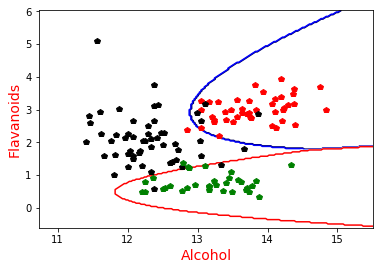

In [64]:
show_decision_boundary(0,6)

In [67]:
datax = testx
datay = testy
@interact(f1 = IntSlider(0,0,12,1), f2 = IntSlider(6,0,12,1))
def show_decision_boundary_interact(f1, f2):
    if f1==f2:
        print("Choose other f1 and f2 values.")
        return
    
    mu, covar, pi = fit_generative_model(datax, datay, [f1,f2])
    x1_lower, x1_upper = find_range(datax[:, f1])
    x2_lower, x2_upper = find_range(datax[:, f2])
    plt.xlim([x1_lower, x1_upper])
    plt.ylim([x2_lower, x2_upper])
    
    colors = ['r','k','g']
    for label in range(1,4):
        plt.plot(datax[datay==label,f1], datax[datay==label,f2], marker='p',ls='None', 
                c=colors[label-1])
        
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)
    
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])
        
        
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0, len(x1g)):
        for j in range(0, len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1
            
    plt.contour(x1g, x2g,Z.T, 3, cmap='seismic')
    
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=12), IntSlider(value=6, description='f2', max=12), Output()), _dom_classes=('widget-interact',))